In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from prophet.diagnostics import performance_metrics

In [49]:
df=pd.read_csv('data_short_term.csv')
df = df.sort_values(by=['ds'])
df.ds = pd.to_datetime(df.ds)
df1 = df.iloc[444:,1:]
df1.index = range(len(df1))
df1

,ds,y,bus_conf,cpi,con_cred,con_exp,real_gdp,gov_con_exp
0,2006-01-01,0.126221,-0.001847,0.006021,-9.985918e-01,0.010056,0.004395,0.004197
1,2006-02-01,0.128887,-0.000833,0.000502,6.943565e+02,0.003344,0.000779,-0.000099
2,2006-03-01,0.125997,-0.000339,0.001502,3.293534e+00,0.003520,0.000778,-0.000099
3,2006-04-01,0.053061,-0.000177,0.004983,4.188877e-01,0.005777,0.000778,-0.000099
4,2006-05-01,0.053175,-0.001478,0.002981,-5.992467e-01,0.004392,0.000515,-0.000478
...,...,...,...,...,...,...,...,...
178,2020-11-01,-0.163321,0.001498,0.001782,1.458659e+07,-0.006447,0.005178,0.004676
179,2020-12-01,-0.170073,0.001919,0.002420,7.996156e-02,-0.005622,0.005151,0.004655
180,2021-01-01,-0.009599,0.001514,0.002559,-9.994608e-01,0.032523,0.005125,0.004633
181,2021-02-01,-0.014997,0.002715,0.003534,2.146443e+04,-0.009859,0.000000,0.000000


In [50]:
variable1 = pd.read_csv('preprocessed_recession_probability.csv')
res = variable1[variable1[variable1.Date=='2006-01-01'].index[0]:variable1[variable1.Date=='2021-03-01'].index[0]+1]
res = res.predicted_probability
res.index = range(len(res))
df1['res'] = res

In [51]:
variable2 = pd.read_csv('preprocessed_Fed_minutes.csv')
fed = variable2[variable2[variable2.date=='2006-01-01'].index[0]:variable2[variable2.date=='2021-03-01'].index[0]+1]
fed = fed.fed_funds_rate
fed.index = range(len(fed))
df1['fed'] = fed

In [57]:
variable3 = pd.read_csv('COVID_Boolean.csv')
covid = variable3[variable3[variable3.Date=='2006-01-01'].index[0]:variable3[variable3.Date=='2021-03-01'].index[0]+1]
covid = covid['COVID Boolean']
covid.index = range(len(covid))
df1['covid'] = covid

In [58]:
df1

,ds,y,bus_conf,cpi,con_cred,con_exp,real_gdp,gov_con_exp,res,fed,covid
0,2006-01-01,0.126221,-0.001847,0.006021,-9.985918e-01,0.010056,0.004395,0.004197,0.386893,3.0,0
1,2006-02-01,0.128887,-0.000833,0.000502,6.943565e+02,0.003344,0.000779,-0.000099,0.386893,3.0,0
2,2006-03-01,0.125997,-0.000339,0.001502,3.293534e+00,0.003520,0.000778,-0.000099,0.539876,3.0,0
3,2006-04-01,0.053061,-0.000177,0.004983,4.188877e-01,0.005777,0.000778,-0.000099,0.219388,3.0,0
4,2006-05-01,0.053175,-0.001478,0.002981,-5.992467e-01,0.004392,0.000515,-0.000478,0.219388,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...
178,2020-11-01,-0.163321,0.001498,0.001782,1.458659e+07,-0.006447,0.005178,0.004676,0.972124,2.0,1
179,2020-12-01,-0.170073,0.001919,0.002420,7.996156e-02,-0.005622,0.005151,0.004655,0.956337,2.0,1
180,2021-01-01,-0.009599,0.001514,0.002559,-9.994608e-01,0.032523,0.005125,0.004633,0.939977,2.0,1
181,2021-02-01,-0.014997,0.002715,0.003534,2.146443e+04,-0.009859,0.000000,0.000000,0.939977,2.0,1


In [59]:
def generate_model_result(df1 = df1, pred_month=1,horizon='30 days',filename='one_month_prediction _EPS.csv'):
    target = pd.DataFrame()
    target['ds'] = pd.to_datetime(df1['ds'])
    target['y'] = df1['y']
    target['cpi']=df1['cpi'].shift(pred_month)
    target['bus_conf']=df1['bus_conf'].shift(pred_month)
    target['con_exp']=df1['con_exp'].shift(pred_month)
    target['real_gdp']=df1['real_gdp'].shift(pred_month)
    target['gov_con_exp']=df1['gov_con_exp'].shift(pred_month)
    target['fed']=df1['fed'].shift(pred_month)
    target['res']=df1['res'].shift(pred_month)
    target.index = range(len(target))
    target = target.drop(list(range(0,pred_month)))
    target.index = range(len(target))
    m = Prophet(seasonality_mode='multiplicative')
    m.add_regressor('cpi')
    m.add_regressor('bus_conf')
    m.add_regressor('con_exp')
    m.add_regressor('real_gdp')
    m.add_regressor('gov_con_exp')
    m.add_regressor('fed')
    m.add_regressor('res')
    m.fit(target)
    df_cv = cross_validation(m, initial='2190 days', period='30 days', horizon = horizon)
    df_cv.to_csv(filename)
    return 0

In [60]:
one_month = [df1,1,'31 days','result/one_month_prediction_EPS.csv']
two_month = [df1,2,'59 days','result/two_month_prediction_EPS.csv']
three_month = [df1,3,'90 days','result/three_month_prediction_EPS.csv']
four_month = [df1,4,'120 days','result/four_month_prediction_EPS.csv']
five_month = [df1,5,'151 days','result/five_month_prediction_EPS.csv']
six_month = [df1,6,'181 days','result/six_month_prediction_EPS.csv']
seven_month = [df1,7,'212 days','result/seven_month_prediction_EPS.csv']
eight_month = [df1,8,'243 days','result/eight_month_prediction_EPS.csv']
nine_month = [df1,9,'273 days','result/nine_month_prediction_EPS.csv']
ten_month = [df1,10,'304 days','result/ten_month_prediction_EPS.csv']
eleven_month = [df1,11,'334 days','result/eleven_month_prediction_EPS.csv']
twelve_month = [df1,12,'365 days','result/twelve_month_prediction_EPS.csv']

In [63]:
for i in [one_month,two_month,three_month,four_month,
          five_month,six_month,seven_month,eight_month,nine_month,
         ten_month,eleven_month,twelve_month]:
    generate_model_result(*i)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 92 forecasts with cutoffs between 2012-11-09 00:00:00 and 2020-05-01 00:00:00


  0%|          | 0/92 [00:00<?, ?it/s]

In [64]:
one_month=pd.read_csv('result/one_month_prediction_EPS.csv')
two_month=pd.read_csv('result/two_month_prediction_EPS.csv')
three_month=pd.read_csv('result/three_month_prediction_EPS.csv')
four_month=pd.read_csv('result/four_month_prediction_EPS.csv')
five_month=pd.read_csv('result/five_month_prediction_EPS.csv')
six_month=pd.read_csv('result/six_month_prediction_EPS.csv')
seven_month=pd.read_csv('result/seven_month_prediction_EPS.csv')
eight_month=pd.read_csv('result/eight_month_prediction_EPS.csv')
nine_month=pd.read_csv('result/nine_month_prediction_EPS.csv')
ten_month=pd.read_csv('result/ten_month_prediction_EPS.csv')
eleven_month=pd.read_csv('result/eleven_month_prediction_EPS.csv')
twelve_month=pd.read_csv('result/twelve_month_prediction_EPS.csv')

In [65]:
def updatedf(df,filename):
    df=df[['ds','yhat','y']]
    df.drop_duplicates(subset='ds',inplace=True)
    df.to_csv(filename)
    return 0

In [66]:
updatedf(one_month,'result/one_month_prediction.csv')
updatedf(two_month,'result/two_month_prediction.csv')
updatedf(three_month,'result/three_month_prediction.csv')
updatedf(four_month,'result/four_month_prediction.csv')
updatedf(five_month,'result/five_month_prediction.csv')
updatedf(six_month,'result/six_month_prediction.csv')
updatedf(seven_month,'result/seven_month_prediction.csv')
updatedf(eight_month,'result/eight_month_prediction.csv')
updatedf(nine_month,'result/nine_month_prediction.csv')
updatedf(ten_month,'result/ten_month_prediction.csv')
updatedf(eleven_month,'result/eleven_month_prediction.csv')
updatedf(twelve_month,'result/twelve_month_prediction.csv')

<ipython-input-65-33a4e24ba45a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='ds',inplace=True)


0

In [2]:
def plot_the_prediction(file):
    df = pd.read_csv(file)
    df['ds']=pd.to_datetime(df['ds'])
    df = df[df[df.ds=='2013-02-01'].index[0]:df[df.ds=='2020-12-01'].index[0]+1]
    df.index=df.ds
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    plt.title('Plot I. One Month Prediction by Rolling Window', fontsize=18)
    plt.ylabel('Modified EPS', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    ax.plot(df.yhat,color='blue',label='EPS Prediction')
    ax.plot(df.y,color='grey', label='Modified EPS')
    ax.legend()
    return 0

0

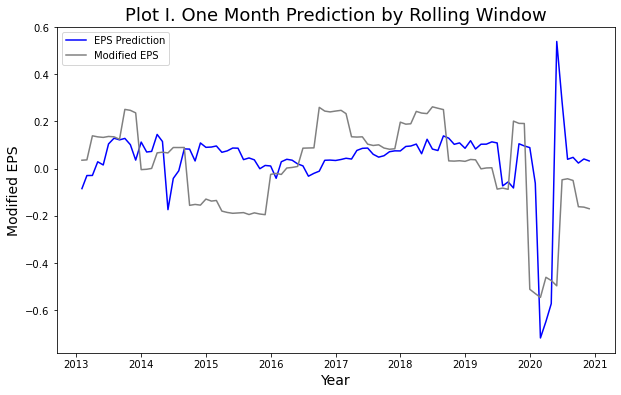

In [3]:
plot_the_prediction('result/one_month_prediction.csv')

In [132]:
def plot_the_residual(file):
    df = pd.read_csv(file)
    df['ds']=pd.to_datetime(df['ds'])
    df = df[df[df.ds=='2013-02-01'].index[0]:df[df.ds=='2020-12-01'].index[0]+1]
    df.index=df.ds
    df.residual=df.yhat-df.y
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    plt.title('Plot II. One Month Prediction Residual', fontsize=18)
    plt.ylabel('Residual', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    ax.scatter(df.index,df.residual,color='blue',label='EPS Prediction')
    ax.hlines(xmin=df.index[0],xmax=df.index[-1],y=0,color = 'red', linestyles='dashed',)
    return 0

<ipython-input-132-7f9a6826ad40>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.residual=df.yhat-df.y


0

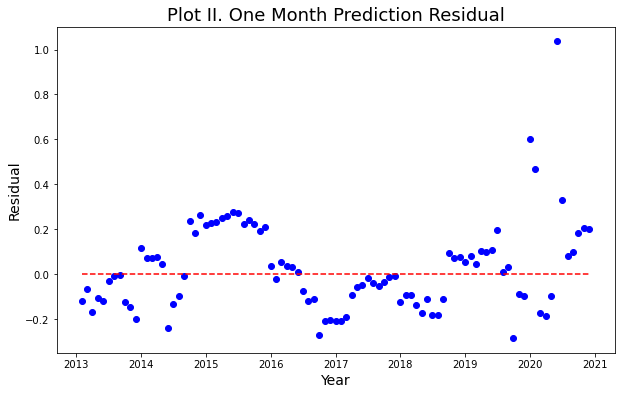